In [1]:
import os
import datetime
import re
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import hashlib
import csv
import json

In [2]:
# functions to read from data files

def read_scheme_stats(data_dir, begin, end):
    df = pd.DataFrame(columns=["date", "expt", "streams", "stall_hrs", "total_hrs", "stall_low", "stall_high", "stall_avg", "ssim_low", "ssim_high", "ssim_avg"])
    date_field = r'(.*)([0-9]{4}-[0-9]{2}-[0-9]{2}T11_[0-9]{4}-[0-9]{2}-[0-9]{2}T11)(.*)' # regex to match date format
    file_suffix = r'day_all_scheme_stats_.*\.txt'
    for d in sorted(os.listdir(data_dir)):
        if (re.match(date_field, d)):
            date = datetime.datetime(int(d.split('-')[0]), int(d.split('-')[1]), int(d.split('-')[2][:2]))
            if (date >= begin and date <= end):
                for f in os.listdir(os.path.join(data_dir, d)):
                    if (re.match(file_suffix, f)):
                        df = pd.concat([df, parse_file(os.path.join(data_dir, d, f), d)])
    df[["ssim_low", "ssim_high", "ssim_avg"]] = df[["ssim_low", "ssim_high", "ssim_avg"]].apply(db_to_raw)
    numeric_cols = ["streams", "stall_hrs", "total_hrs", "stall_low", "stall_high", "stall_avg", "ssim_low", "ssim_high", "ssim_avg"]
    df[numeric_cols] = df[df[numeric_cols] > 0][numeric_cols]
    return df.dropna()

def parse_file(filepath, date):
    stats1 = r'#(.+) considered ([0-9]+) streams, stall\/watch hours: (.+)\/(.+)'
    stats2 = r'(.+) stall ratio \(95% CI\): (.+)% \.\. (.+)%, mean= (.+); SSIM \(95% CI\): (.+) .. (.+), mean= (.+); SSIMvar \(95% CI\): (.+) .. (.+), mean= (.+)'
    data = {}
    with open(filepath, 'r') as file_object:
        line = file_object.readline()
        while line:
            if (line[0] == '#'):
                result = re.search(stats1, line).groups()
                data[result[0]] = [date, result[0], int(result[1]), float(result[2]), float(result[3])]
            else:
                result = re.search(stats2, line).groups()
                data[result[0]].extend([float(result[1]), float(result[2]), float(result[3]), float(result[4]), float(result[5]), float(result[6])])
            line = file_object.readline()
    return pd.DataFrame.from_dict(data, orient='index', columns=["date", "expt", "streams", "stall_hrs", "total_hrs", "stall_low", "stall_high", "stall_avg", "ssim_low", "ssim_high", "ssim_avg"])

def read_stream_stats(data_dir, begin, end):
    df = pd.DataFrame(columns=["ts", "validity", "fulltrunc", "badreason", "scheme", "extent", 
                               "usedpct", "ssim", "delivery_rate", "bitrate_avg", "ssimvar", 
                               "startup_delay", "watch_time", "stall_time"])
    date_field = r'(.*)([0-9]{4}-[0-9]{2}-[0-9]{2}T11_[0-9]{4}-[0-9]{2}-[0-9]{2}T11)(.*)' # regex to match date format
    file_suffix = r'stream_stats_.*\.txt'
    for d in sorted(os.listdir(data_dir)):
        if (re.match(date_field, d)):
            date = datetime.datetime(int(d.split('-')[0]), int(d.split('-')[1]), int(d.split('-')[2][:2]))
            if (date >= begin and date <= end):
                for f in os.listdir(os.path.join(data_dir, d)):
                    if (re.match(file_suffix, f)):
                        df = pd.concat([df, parse_stream(os.path.join(data_dir, d, f), d)])
    cols = ["ts", "ssim", "delivery_rate", "bitrate_avg", "ssimvar", "startup_delay", "watch_time"]
    df[cols] = df[df[cols] > 0][cols]
    df['stall_time'] = 100 * df['stall_time'] / df['watch_time']
    #df['scheme'] = df.scheme.str.split('/', expand=True)[0]
    return df.dropna()

def parse_stream(filepath, date):
    line_format = r'ts=(.*) valid=(.*) full_extent=(.*) bad_reason=(.*) scheme=(.*) extent=(.*) used=(.*)% mean_ssim=(.*) mean_delivery_rate=(.*) average_bitrate=(.*) ssim_variation_db=(.*) startup_delay=(.*) total_after_startup=(.*) stall_after_startup=(.*)'
    data = []
    with open(filepath, 'r') as file_object:
        line = file_object.readline()
        while line:
            if (line[0] != '#'):
                results = re.search(line_format, line).groups()
                if (results[1] == "bad"):
                    line = file_object.readline()
                    continue
                data.append((int(results[0]), results[1], results[2], results[3], results[4], float(results[5]), float(results[6]), float(results[7]), float(results[8]), float(results[9]), float(results[10]), float(results[11]), float(results[12]), float(results[13])))
            line = file_object.readline()
    return pd.DataFrame(data, columns=["ts", "validity", "fulltrunc", "badreason", "scheme", "extent", 
                                       "usedpct", "ssim", "delivery_rate", "bitrate_avg", "ssimvar", 
                                       "startup_delay", "watch_time", "stall_time"])

def read_buffer(data_dir, begin, end):
    df = pd.DataFrame(columns=['date', 'expt_id', 'time', 'stall_len', 'stream_len'])
    date_field = r'(.*)([0-9]{4}-[0-9]{2}-[0-9]{2}T11_[0-9]{4}-[0-9]{2}-[0-9]{2}T11)(.*)' # regex to match date format
    file_suffix = r'client_buffer_.*\.csv'
    for d in sorted(os.listdir(data_dir)):
        if (re.match(date_field, d)):
            date = datetime.datetime(int(d.split('-')[0]), int(d.split('-')[1]), int(d.split('-')[2][:2]))
            if (date >= begin and date <= end):
                for f in os.listdir(os.path.join(data_dir, d)):
                    if (re.match(file_suffix, f)):
                        df = pd.concat([df, parse_buffer(os.path.join(data_dir, d, f), os.path.join(data_dir, d, 'logs/expt_settings'), d)])
    df = df[df['stall_len'] > 0]
    df = df[df['time'] > 0]
    return df.reset_index()

def parse_buffer(filepath, settings_path, date):
    data = {} # relative time, index, expt_id, channel, event, buffer, cum_rebuf
    metadata = {} # start time, total time, cum rebuf at start, cum rebuf at last play, time at startup, time at last play, bad, last buffer, last cum rebuf, playing, started
    with open(settings_path, 'r') as file_object:
        expt_data = []
        for line in file_object.readlines():
            expt_id = line.split(' ', 1)[0]
            abr = json.loads(line.split(' ', 1)[1]).get('abr')
            if (abr != None):
                expt_data.append((expt_id, abr))
        
    with open(filepath, 'r') as file_object:
        csvFile = csv.reader(file_object)
        first = 0
        for line in csvFile:
            if (first == 0):
                first += 1
                continue
            if (line[3] in data):
                time = (int(line[0]) - metadata[line[3]][0]) / 1000000000.0
                data[line[3]].append((time, int(line[2]), int(line[3]), line[4], line[5], float(line[6]), float(line[7])))
            else:
                data[line[3]] = [(0, int(line[2]), int(line[3]), line[4], line[5], float(line[6]), float(line[7]))]
                metadata[line[3]] = [int(line[0]), 0, 0, 0, 0, 0, False, float(line[6]), float(line[7]), False, False]
            if (metadata[line[3]][6]):
                continue
            if (float(line[6]) > 5 and metadata[line[3]][7] > 5 and float(line[7]) > metadata[line[3]][8] + 0.15):
                metadata[line[3]][6] = True
            if (line[5] == "play"):
                metadata[line[3]][9] = True
                metadata[line[3]][5] = data[line[3]][-1][0]
                metadata[line[3]][3] = data[line[3]][-1][6]
            elif (line[5] == "startup"):
                if (not metadata[line[3]][10]):
                    metadata[line[3]][4] = data[line[3]][-1][0]
                    metadata[line[3]][2] = float(line[7])
                    metadata[line[3]][10] = True
                metadata[line[3]][9] = True
                metadata[line[3]][5] = data[line[3]][-1][0]
                metadata[line[3]][3] = data[line[3]][-1][6]
            elif (line[5] == "timer"):
                if (metadata[line[3]][9]):
                    metadata[line[3]][5] = data[line[3]][-1][0]
                    metadata[line[3]][3] = data[line[3]][-1][6]
            elif (line[5] == "rebuffer"):
                metadata[line[3]][9] = False

    for expt_id in list(data.keys()):
        if (metadata[expt_id][5] <= metadata[expt_id][4]):
            del data[expt_id]
            del metadata[expt_id]
            continue
        if (metadata[expt_id][3] <= metadata[expt_id][2]):
            del data[expt_id]
            del metadata[expt_id]
            continue
        if (not metadata[expt_id][10] or metadata[expt_id][6]):
            del data[expt_id]
            del metadata[expt_id]
            continue
        data[expt_id].sort(key=lambda x: x[0])
        metadata[expt_id][1] = data[expt_id][-1][0]
        #print(f"id: {expt_id}, start: {metadata[expt_id][0]}, total time: {metadata[expt_id][1]}, startup stall: {metadata[expt_id][2]}, stall after start: {metadata[expt_id][3]}")
    
    stall_data = []
    for expt_id, events in data.items():
        stall_data.append((date, expt_id, 0, metadata[expt_id][2], metadata[expt_id][1]))
        buffering = False
        prev_rebuf = 0
        for event in events:
            if (event[4] == "rebuffer"):
                buffering = True
                last_rebuf = event
            elif (buffering and prev_rebuf == event[6]):
                stall_data.append((date, expt_id, last_rebuf[0], event[6] - last_rebuf[6], metadata[expt_id][1]))
                buffering = False
            prev_rebuf = event[6]
    df = pd.DataFrame(stall_data, columns=['date', 'expt_id', 'time', 'stall_len', 'stream_len'])
    expt_df = pd.DataFrame(expt_data, columns=['expt_id2', 'abr'])
    df = df.merge(expt_df, how='inner', left_on='expt_id', right_on='expt_id2')
    df = df.drop(columns=['expt_id2'])
    return df

def raw_to_db(ssim):
    return -10 * math.log10(1 - ssim)

def db_to_raw(ssim):
    return 1 - 10**(-ssim / 10)

In [5]:
# data directory
data_dir = "/scratch/tn2208/puffer/puffer-data-release"
# date range for analysis
begin_date = datetime.datetime(2022, 2, 1)
end_date = datetime.datetime(2022, 10, 1)
num_days = (end_date - begin_date).days + 1
#num_days += (datetime.datetime(2019, 10, 15) - datetime.datetime(2019, 8, 30)).days + 1
print(f'Number of days: {num_days}')
df = read_scheme_stats(data_dir, begin_date, end_date)
#df = df.append(read_scheme_stats(data_dir, datetime.datetime(2019, 8, 30), datetime.datetime(2019, 10, 15)))
df.reset_index(drop=True, inplace=True)
display(df)

Number of days: 243


,date,expt,streams,stall_hrs,total_hrs,stall_low,stall_high,stall_avg,ssim_low,ssim_high,ssim_avg
0,2022-02-08T11_2022-02-09T11,fugu_variant_cl/bbr,1004,0.127,157.723,0.004649,0.196909,0.069420,0.953557,0.963990,0.958774
1,2022-02-08T11_2022-02-09T11,fugu_variant_cl2/bbr,975,0.509,160.866,0.088658,0.659299,0.328552,0.965639,0.973801,0.969720
2,2022-02-08T11_2022-02-09T11,linear_bba/bbr,1006,0.407,161.048,0.059216,0.450003,0.217608,0.980953,0.983126,0.982040
3,2022-02-08T11_2022-02-09T11,puffer_ttp_20190202/bbr,1000,0.460,177.675,0.103123,0.401053,0.222752,0.980397,0.982830,0.981613
4,2022-02-08T11_2022-02-09T11,puffer_ttp_cl/bbr,923,0.059,174.445,0.011780,0.064676,0.033208,0.981411,0.982776,0.982093
...,...,...,...,...,...,...,...,...,...,...,...
1655,2022-10-01T11_2022-10-02T11,linear_bba/bbr,3270,0.803,573.443,0.080350,0.228637,0.147720,0.974283,0.977625,0.975954
1656,2022-10-01T11_2022-10-02T11,maguro/bbr,3072,0.155,591.309,0.010018,0.042803,0.023344,0.976443,0.978604,0.977523
1657,2022-10-01T11_2022-10-02T11,puffer_ttp_20190202/bbr,3273,0.449,561.400,0.026210,0.140115,0.073358,0.976387,0.978351,0.977369
1658,2022-10-01T11_2022-10-02T11,puffer_ttp_cl/bbr,2947,0.451,659.982,0.034712,0.124469,0.073955,0.976889,0.978910,0.977900


In [6]:
# calculate aggregated statistics from scheme stats
df['watch_time'] = df['total_hrs'] * 3600
df['weighted_ssim'] = df['ssim_avg'] * df['watch_time']
df['stall_avg_log'] = np.log2(df['stall_avg'])
df['stall_low_log'] = np.log2(df['stall_low'])
df['stall_high_log'] = np.log2(df['stall_high'])
df['weighted_stall'] = df['stall_avg_log'] * df['watch_time']
df['weighted_ssimvar'] = df['watch_time'] * (df['ssim_high'] - df['ssim_low'])**2 / 4 
df['weighted_stallvar_low'] = df['watch_time']**2 * (df['stall_avg_log'] - df['stall_low_log'])**2 / 4
df['weighted_stallvar_high'] = df['watch_time']**2 * (df['stall_high_log'] - df['stall_avg_log'])**2 / 4

temp = df.groupby(['expt'])
grouped_df = temp.agg(ssim_avg=('weighted_ssim', 'sum'), ssim_std=('weighted_ssimvar', 'sum'), stall_avg=('weighted_stall', 'sum'),
                      stall_std_low=('weighted_stallvar_low', 'sum'), stall_std_high=('weighted_stallvar_high', 'sum'))
grouped_df['ssim_avg'] /= temp['watch_time'].sum()
grouped_df['stall_avg'] /= temp['watch_time'].sum()
grouped_df['ssim_std'] = np.sqrt(grouped_df['ssim_std'] / temp['watch_time'].sum())
grouped_df['stall_std_low'] = np.sqrt(grouped_df['stall_std_low'] / temp['watch_time'].sum()**2)
grouped_df['stall_std_high'] = np.sqrt(grouped_df['stall_std_high'] / temp['watch_time'].sum()**2)

grouped_df['ssim_avg'] = grouped_df['ssim_avg'].apply(raw_to_db)
grouped_df['ssim_std'] = grouped_df['ssim_std'].apply(raw_to_db)
grouped_df['ssim_low'] = grouped_df['ssim_avg'] - 2 * grouped_df['ssim_std']
grouped_df['ssim_high'] = grouped_df['ssim_avg'] + 2 * grouped_df['ssim_std']
grouped_df['stall_low'] = grouped_df['stall_avg'] - 2 * grouped_df['stall_std_low']
grouped_df['stall_high'] = grouped_df['stall_avg'] + 2 * grouped_df['stall_std_high']

#logs
grouped_df['stall_avg'] = np.power(2, grouped_df['stall_avg'])
grouped_df['stall_low'] = np.power(2, grouped_df['stall_low'])
grouped_df['stall_high'] = np.power(2, grouped_df['stall_high'])

grouped_df.reset_index(inplace=True)
display(grouped_df)

,expt,ssim_avg,ssim_std,stall_avg,stall_std_low,stall_std_high,ssim_low,ssim_high,stall_low,stall_high
0,bola_causalsim/bbr,16.664328,0.005925,0.064638,0.128045,0.079280,16.652477,16.676179,0.054125,0.072147
1,causalsim_rl/bbr,16.828049,0.007194,0.092689,0.120513,0.081002,16.813661,16.842436,0.078428,0.103704
2,fugu_variant_cl/bbr,13.462411,0.023883,0.047509,0.144994,0.067106,13.414645,13.510176,0.038858,0.052141
3,fugu_variant_cl2/bbr,14.774438,0.021343,0.069585,0.127543,0.062829,14.731751,14.817125,0.058308,0.075918
4,fugu_variant_cl3/bbr,16.853065,0.006489,0.050079,0.103777,0.051554,16.840088,16.866042,0.043369,0.053789
5,fugu_variant_cl4/bbr,14.975582,0.012596,0.045269,0.111268,0.054375,14.950389,15.000774,0.038798,0.048813
6,linear_bba/bbr,16.965782,0.006669,0.099151,0.062016,0.035517,16.952444,16.979120,0.090983,0.104155
7,maguro/bbr,17.098013,0.005084,0.026423,0.071129,0.038312,17.087846,17.108180,0.023942,0.027864
8,puffer_ttp_20190202/bbr,16.991615,0.006021,0.073778,0.063020,0.036327,16.979572,17.003657,0.067606,0.077589
9,puffer_ttp_cl/bbr,17.000044,0.005705,0.061415,0.058139,0.034233,16.988633,17.011454,0.056660,0.064400


In [7]:
common_schemes = {
     'puffer_ttp_cl/bbr': ['Fugu', 'tab:red'], 
     'linear_bba/bbr': ['BBA', 'tab:green'], 
     'pensieve/bbr': ['Pensieve', 'tab:purple'], 
     'pensieve_in_situ/bbr': ['Pensieve (Puffer traces)', 'tab:pink'],
     'mpc/bbr': ['MPC-HM', 'tab:blue'], 
     'robust_mpc/bbr': ['RobustMPC-HM', 'tab:brown'], 
     'puffer_ttp_20190202/bbr': ['Fugu-Feb', 'tab:orange'], 
     'puffer_ttp_20190302/bbr': ['Fugu-Mar', 'tab:olive'],
     'puffer_ttp_20190402/bbr': ['Fugu-Apr', 'tab:cyan'], 
     'puffer_ttp_20190502/bbr': ['Fugu-May', 'tab:gray'],
     'fugu_variant_cl/bbr': ['Memento', '#0f6c44'],
     'fugu_variant_cl3/bbr': ['Memento-v3a', '#bc61f5'],
     'fugu_variant_cl4/bbr': ['Memento-v3b', '#461257'],
}

# Keep name => color mapping consistent across experiments and runs.
# No matplotlib colormaps to avoid duplicating colors.
def get_color(name):
    # Assign static colors to the common schemes. 
    # For others, hash the name.
    if name in common_schemes:
        return common_schemes[name][1]
    else:
        # hashlib sha is deterministic unlike hash() 
        sha = hashlib.sha256()      
        sha.update(name.encode())
        return '#' + sha.hexdigest()[:6]
    
def plot_data(data, output_figure, title):
    fig, ax = plt.subplots()
    ax.set_xlabel('Time spent stalled (%)')
    ax.set_ylabel('Average SSIM (dB)')

    for _, row in data.iterrows():
        
        name = row['expt']
        x = row['stall_avg']
        y = row['ssim_avg']
        
        pretty_name = name if name not in common_schemes else common_schemes[name][0]
        if (pretty_name not in ["BBA", "MPC-HM", "Pensieve", "Fugu", "RobustMPC-HM", "Fugu-Feb", "Memento-v3a"]):
            continue
        pretty_color = get_color(name)
        
        ax.scatter(x, y, color=pretty_color, label=pretty_name)
        ax.errorbar(x, y,
            xerr=[[x - row['stall_low']], [row['stall_high'] - x]],
            yerr=[[y - row['ssim_low']], [row['ssim_high'] - y]],
            ecolor=pretty_color,
            capsize=4.0)
        # Labels are often very overlapping -- try legend
        #ax.annotate(pretty_name, (x, y),
        #            xytext=(4,5), textcoords='offset pixels')
        ax.legend()

    #subtitle = '{} streams, {:.0f} stream-hours'.format(data['streams'].sum(), data['total_hrs'].sum())
    #plt.title(title + '\n(' + subtitle + ')' if title else subtitle)
    ax.invert_xaxis()

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    fig.savefig(output_figure)
    print('Saved plot to {}\n'.format(output_figure))

Saved plot to 2022-02-01_2022-10-01.svg



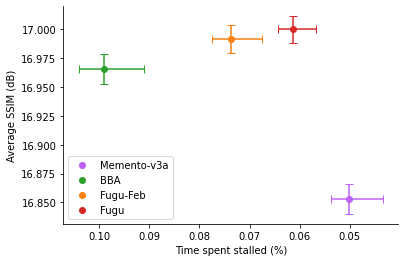

In [8]:
plot_data(grouped_df, "2022-02-01_2022-10-01.svg", "All stream speeds, 2019-01-26")

In [5]:
# create expt_df to plot experiment history
df['pretty_name'] = df['expt'].apply(lambda x: common_schemes.get(x, (x,0))[0])
df['date'] = df['date'].str.slice(stop=10)
expt_df = df.groupby(['pretty_name', 'date']).agg(streams=('streams', 'sum'), total_hrs=('total_hrs', 'sum'))
expt_df.reset_index(inplace=True)
expt_df['streams_norm'] = expt_df['streams'] / expt_df.groupby('date')['streams'].transform('sum')
display(expt_df)

,pretty_name,date,streams,total_hrs,streams_norm
0,BBA,2019-01-26,268,15.399,0.076571
1,BBA,2019-01-27,358,43.538,0.074089
2,BBA,2019-01-28,188,38.229,0.092474
3,BBA,2019-01-29,190,26.970,0.137283
4,BBA,2019-02-02,179,26.699,0.098082
...,...,...,...,...,...
3682,robust_mpc/cubic,2019-03-05,61,14.321,0.236434
3683,robust_mpc/cubic,2019-03-07,58,13.065,0.166667
3684,robust_mpc/cubic,2019-03-10,118,19.360,0.148615
3685,robust_mpc/cubic,2019-03-13,58,3.419,0.119342


In [10]:
df_pivot = expt_df.pivot(index='pretty_name', columns='date', values='streams_norm').fillna(0)
display(df_pivot)

date,2019-01-26,2019-01-27,2019-01-28,2019-01-29,2019-01-30,2019-01-31,2019-02-01,2019-02-02,2019-02-03,2019-02-04,...,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-14,2020-12-15
pretty_name,,,,,,,,,,,,,,,,,,,,,
BBA,0.076571,0.074089,0.092474,0.137283,0.000000,0.000000,0.000000,0.098082,0.064394,0.000000,...,0.206614,0.200395,0.181143,0.190607,0.204749,0.192239,0.205232,0.229011,0.176505,0.178973
Fugu,0.085143,0.110099,0.127398,0.171243,0.000000,0.000000,0.143454,0.000000,0.087121,0.000000,...,0.211688,0.196999,0.217428,0.196554,0.203217,0.161552,0.219795,0.195604,0.221071,0.212094
Fugu-Apr,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fugu-Feb,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.162128,0.211635,0.198375,0.232540,0.199387,0.236785,0.201996,0.195341,0.218139,0.232148
Fugu-Mar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fugu-May,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MPC-HM,0.083714,0.084644,0.077718,0.000000,0.094527,0.121387,0.149025,0.068493,0.078598,0.217290,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pensieve,0.092571,0.084230,0.000000,0.093931,0.095522,0.137572,0.000000,0.143562,0.074100,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pensieve (Puffer traces),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


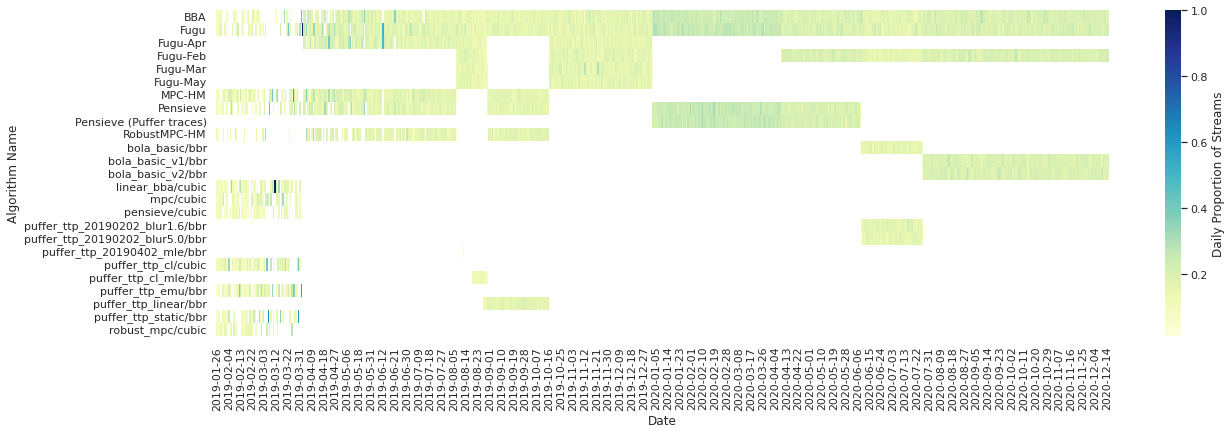

In [12]:
# plot experiment history
import seaborn as sns

sns.set_theme(style="whitegrid", palette="pastel")
fig, ax = plt.subplots(figsize=(20,6))
sns_plot = sns.heatmap(df_pivot,ax=ax,mask=(df_pivot==0),cmap='YlGnBu')
sns_plot.collections[0].colorbar.set_label('Daily Proportion of Streams')
plt.xlabel('Date')
plt.ylabel('Algorithm Name')

plt.show()

In [6]:
# read stream data from original date range and 2020 date range
df2_original = read_stream_stats(data_dir, datetime.datetime(2019, 1, 26), datetime.datetime(2019, 8, 6))
df2_original = df2_original.append(read_stream_stats(data_dir, datetime.datetime(2019, 8, 30), datetime.datetime(2019, 10, 15)))
df2_original = df2_original[df2_original['stall_time'] <= df2_original['watch_time']]
df2_original.reset_index(drop=True, inplace=True)
df2_original['datetime'] = pd.to_datetime(df2_original['ts'], unit='s').dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df2_original['hour'] = df2_original['datetime'].dt.hour
df2_original['weighted_ssim'] = df2_original['ssim'] * df2_original['watch_time']
df2_original['weighted_delivery_rate'] = df2_original['delivery_rate'] * df2_original['watch_time']

df2_new = read_stream_stats(data_dir, datetime.datetime(2020, 3, 15), datetime.datetime(2020, 11, 9))
df2_new = df2_new[df2_new['stall_time'] <= df2_new['watch_time']]
df2_new.reset_index(drop=True, inplace=True)
df2_new['datetime'] = pd.to_datetime(df2_new['ts'], unit='s').dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
df2_new['hour'] = df2_new['datetime'].dt.hour
df2_new['weighted_ssim'] = df2_new['ssim'] * df2_new['watch_time']
df2_new['weighted_delivery_rate'] = df2_new['delivery_rate'] * df2_new['watch_time']

display(df2_original)

,ts,validity,fulltrunc,badreason,scheme,extent,usedpct,ssim,delivery_rate,bitrate_avg,ssimvar,startup_delay,watch_time,stall_time,datetime,hour,weighted_ssim,weighted_delivery_rate
0,1548705532,good,full,good,robust_mpc/bbr,3.848000,100.000000,0.858946,9.825075e+04,1.433966e+05,0.680574,3.034,0.802000,0.0,2019-01-28 11:58:52-08:00,11,0.688875,7.879710e+04
1,1548710542,good,full,good,robust_mpc/bbr,89.103996,100.000000,0.975782,1.853180e+06,2.900620e+06,0.442870,0.147,88.954994,0.0,2019-01-28 13:22:22-08:00,13,86.800682,1.648496e+08
2,1548733796,good,full,good,puffer_ttp_cl/bbr,2.192000,100.000000,0.916503,2.592140e+05,7.457582e+05,2.004898,0.402,1.797000,0.0,2019-01-28 19:49:56-08:00,19,1.646956,4.658076e+05
3,1548729321,good,full,good,puffer_ttp_emu/bbr,2.888000,99.999992,0.965034,8.382948e+06,2.678286e+06,0.607933,0.094,2.781000,0.0,2019-01-28 18:35:21-08:00,18,2.683760,2.331298e+07
4,1548759109,good,full,good,puffer_ttp_cl/cubic,2.181000,100.000000,0.982969,4.088743e+06,2.625541e+06,0.314489,0.131,2.048000,0.0,2019-01-29 02:51:49-08:00,2,2.013121,8.373746e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1396831,1571196067,good,full,good,mpc/bbr,1.320000,99.999992,0.970063,1.388290e+06,2.620690e+06,4.156292,0.172,1.148000,0.0,2019-10-15 20:21:07-07:00,20,1.113632,1.593756e+06
1396832,1571153218,good,full,good,robust_mpc/bbr,11.070000,100.000000,0.917899,6.763966e+06,2.476742e+06,1.773032,0.320,10.750000,0.0,2019-10-15 08:26:58-07:00,8,9.867414,7.271263e+07
1396833,1571151545,good,full,good,puffer_ttp_cl/bbr,1.361000,100.000000,0.982763,1.369066e+07,3.442166e+06,0.440648,0.110,1.251000,0.0,2019-10-15 07:59:05-07:00,7,1.229437,1.712701e+07
1396834,1571137670,good,full,good,puffer_ttp_linear/bbr,57.383999,100.000000,0.978361,2.015060e+06,4.713412e+06,0.347674,0.363,57.021000,0.0,2019-10-15 04:07:50-07:00,4,55.787123,1.149007e+08


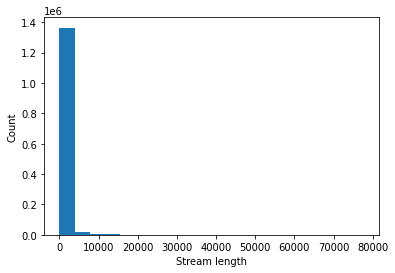

In [7]:
# plot stream length distribution
n, bins, rects = plt.hist(df2_original['watch_time'], bins=20)
plt.xlabel("Stream length")
plt.ylabel("Count")
plt.savefig('stream-length.png')
plt.show()

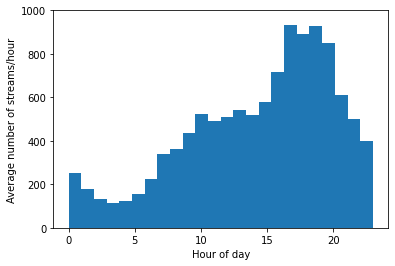

In [21]:
# plot hourly distribution of streams/hr
n, bins, rects = plt.hist(df2_original['hour'], bins=24)
for r in rects:
    r.set_height(r.get_height() / num_days)
plt.ylim(0,1000)
plt.xlabel("Hour of day")
plt.ylabel("Average number of streams/hour")
plt.savefig('streams-hour_2020-03-15_2020-11-09.png')
plt.show()

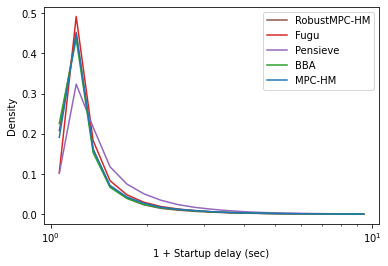

In [23]:
# plot distribution of startup times
df2_original['startup_log'] = np.log2(1 + df2_original['startup_delay'])

for scheme in df2_original.scheme.unique():
    if (scheme not in ['puffer_ttp_cl/bbr', 'linear_bba/bbr', 'pensieve/bbr', 'mpc/bbr', 'robust_mpc/bbr']):
        continue
    bins = np.logspace(0, 1, 20)
    n, x = np.histogram(df2_original[df2_original['scheme'] == scheme]['startup_delay'] + 1, bins=bins)
    n = n / n.sum()
    bin_centers = 0.5 * (x[1:] + x[:-1])
    plt.plot(bin_centers, n, label=common_schemes[scheme][0], color=common_schemes[scheme][1])
plt.legend(loc='upper right')
plt.xlabel("1 + Startup delay (sec)")
plt.xscale("log")
plt.ylabel("Density")
plt.savefig('startup-delay.png')
plt.show()

In [46]:
# find per-hour distribution of ssim/delivery rate/stalls
df2_original = df2_original[df2_original['scheme'] == 'puffer_ttp_cl/bbr']
temp2_original = df2_original.groupby(['hour'])
grouped_df2_original = temp2_original.agg(ssim_avg=('weighted_ssim', 'sum'), delivery_rate_avg=('weighted_delivery_rate', 'sum'), stall_avg=('stall_time', 'sum'))
grouped_df2_original['ssim_avg'] /= temp2_original['watch_time'].sum()
grouped_df2_original['delivery_rate_avg'] /= temp2_original['watch_time'].sum()
grouped_df2_original['stall_avg'] = 100 * grouped_df2_original['stall_avg'] / temp2_original['watch_time'].sum()
grouped_df2_original['ssim_avg'] = grouped_df2_original['ssim_avg'].apply(raw_to_db)
grouped_df2_original.reset_index(inplace=True)

df2_new = df2_new[df2_new['scheme'] == 'puffer_ttp_cl/bbr']
temp2_new = df2_new.groupby(['hour'])
grouped_df2_new = temp2_new.agg(ssim_avg=('weighted_ssim', 'sum'), delivery_rate_avg=('weighted_delivery_rate', 'sum'), stall_avg=('stall_time', 'sum'))
grouped_df2_new['ssim_avg'] /= temp2_new['watch_time'].sum()
grouped_df2_new['delivery_rate_avg'] /= temp2_new['watch_time'].sum()
grouped_df2_new['stall_avg'] = 100 * grouped_df2_new['stall_avg'] / temp2_new['watch_time'].sum()
grouped_df2_new['ssim_avg'] = grouped_df2_new['ssim_avg'].apply(raw_to_db)
grouped_df2_new.reset_index(inplace=True)

display(grouped_df2_original)

,hour,ssim_avg,delivery_rate_avg,stall_avg
0,0,17.098458,7.667142e+06,0.053062
1,1,17.225167,4.857155e+06,0.080984
2,2,17.268621,4.752749e+06,0.140976
3,3,17.269666,4.103565e+06,0.079816
4,4,16.937770,4.351199e+06,0.079855
5,5,16.390526,9.169240e+06,0.034515
6,6,16.981816,1.122984e+07,0.023579
7,7,17.016338,9.367104e+06,0.012451
8,8,16.581659,6.001922e+06,0.019140
9,9,16.396160,7.508702e+06,0.026319


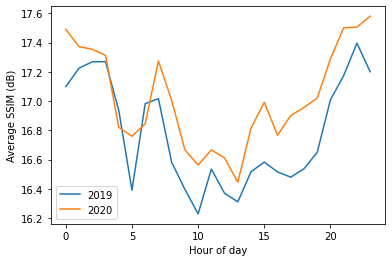

In [40]:
# plot comparison of average hourly ssim
plt.plot(grouped_df2_original['hour'], grouped_df2_original['ssim_avg'], label='2019')
plt.plot(grouped_df2_new['hour'], grouped_df2_new['ssim_avg'], label='2020')
plt.xlabel("Hour of day")
plt.ylabel("Average SSIM (dB)")
plt.legend()
plt.savefig('ssim-hour_comparison.png')
plt.show()

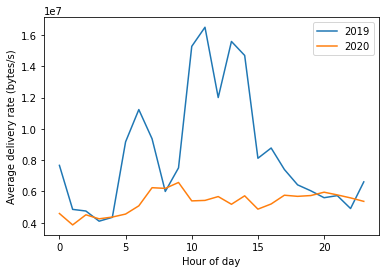

In [42]:
# plot comparison of average hourly delivery rate
plt.plot(grouped_df2_original['hour'], grouped_df2_original['delivery_rate_avg'], label='2019')
plt.plot(grouped_df2_new['hour'], grouped_df2_new['delivery_rate_avg'], label='2020')
plt.xlabel("Hour of day")
plt.ylabel("Average delivery rate (bytes/s)")
plt.legend()
plt.savefig('delivery-rate-hour_comparison.png')
plt.show()

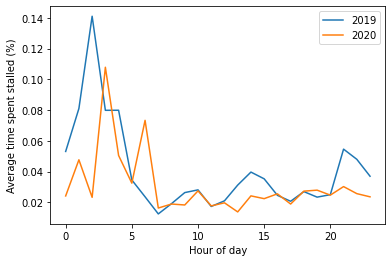

In [44]:
# plot comparison of average hourly stall ratio
plt.plot(grouped_df2_original['hour'], grouped_df2_original['stall_avg'], label='2019')
plt.plot(grouped_df2_new['hour'], grouped_df2_new['stall_avg'], label='2020')
plt.xlabel("Hour of day")
plt.ylabel("Average time spent stalled (%)")
plt.legend()
plt.savefig('stall-hour_comparison.png')
plt.show()

In [7]:
# read from raw buffer file to find stall occurrences, takes ~2 hrs on 9-month date range
stall_df = read_buffer("/scratch/tn2208/puffer/puffer-data-release", datetime.datetime(2019, 1, 26), datetime.datetime(2019, 10, 15))
display(stall_df)

,index,date,expt_id,time,stall_len,stream_len,abr
0,1,2019-01-26T11_2019-01-27T11,230,11967.789,8.551,14155.478,puffer_ttp
1,2,2019-01-26T11_2019-01-27T11,230,11976.930,5.387,14155.478,puffer_ttp
2,4,2019-01-26T11_2019-01-27T11,230,12290.833,0.192,14155.478,puffer_ttp
3,5,2019-01-26T11_2019-01-27T11,230,13940.437,0.346,14155.478,puffer_ttp
4,7,2019-01-26T11_2019-01-27T11,236,4225.808,0.199,29009.887,robust_mpc
...,...,...,...,...,...,...,...
100735,457,2019-10-15T11_2019-10-16T11,831,50205.271,0.048,77177.855,mpc
100736,459,2019-10-15T11_2019-10-16T11,831,51634.676,0.352,77177.855,mpc
100737,460,2019-10-15T11_2019-10-16T11,831,52327.216,1.300,77177.855,mpc
100738,462,2019-10-15T11_2019-10-16T11,831,54780.879,1.787,77177.855,mpc


In [22]:
grouped_stall_df = stall_df.groupby(['date', 'expt_id', 'stream_len'], as_index=False).count()
display(grouped_stall_df)

,date,expt_id,stream_len,index,time,stall_len,abr
0,2019-01-26T11_2019-01-27T11,230,14155.478,4,4,4,4
1,2019-01-26T11_2019-01-27T11,234,27332.149,15,15,15,15
2,2019-01-26T11_2019-01-27T11,236,29009.887,23,23,23,23
3,2019-01-26T11_2019-01-27T11,240,16753.359,22,22,22,22
4,2019-01-26T11_2019-01-27T11,241,8200.410,18,18,18,18
...,...,...,...,...,...,...,...
1019,2019-10-14T11_2019-10-15T11,836,61601.300,61,61,61,61
1020,2019-10-15T11_2019-10-16T11,830,80449.290,67,67,67,67
1021,2019-10-15T11_2019-10-16T11,831,77177.855,70,70,70,70
1022,2019-10-15T11_2019-10-16T11,836,4747.214,12,12,12,12


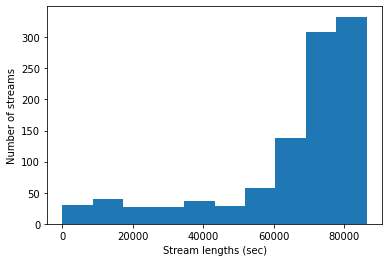

In [30]:
# plot distribution of stream lengths with stalls
plt.hist(grouped_stall_df['stream_len'])
plt.xlabel("Stream lengths (sec)")
plt.ylabel("Number of streams")
plt.show()

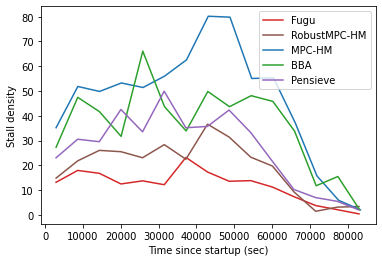

In [28]:
# plot distribution of stream occurrences
scheme_to_label = {'puffer_ttp': ['Fugu', 'tab:red'], 'linear_bba': ['BBA', 'tab:green'], 
                   'pensieve': ['Pensieve', 'tab:purple'], 'mpc': ['MPC-HM', 'tab:blue'], 
                   'robust_mpc': ['RobustMPC-HM', 'tab:brown']} 

for scheme in stall_df.abr.unique():
    if (scheme not in scheme_to_label):
        continue
    n, x = np.histogram(stall_df[stall_df['abr'] == scheme]['time'], 15)
    bin_centers = 0.5 * (x[1:] + x[:-1])
    plt.plot(bin_centers, n / stall_df[stall_df['abr'] == scheme]['expt_id'].nunique(), label=scheme_to_label[scheme][0], color=scheme_to_label[scheme][1])
plt.legend(loc='upper right')
plt.xlabel("Time since startup (sec)")
plt.ylabel("Stall density")
plt.savefig('stall-time.png')
plt.show()

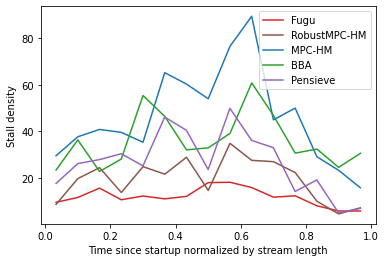

In [29]:
# plot normalized distribution of stream occurrences
for scheme in stall_df.abr.unique():
    if (scheme not in scheme_to_label):
        continue
    n, x = np.histogram(stall_df[stall_df['abr'] == scheme]['time'] / stall_df[stall_df['abr'] == scheme]['stream_len'], 15)
    bin_centers = 0.5 * (x[1:] + x[:-1])
    plt.plot(bin_centers, n / stall_df[stall_df['abr'] == scheme]['expt_id'].nunique(), label=scheme_to_label[scheme][0], color=scheme_to_label[scheme][1])
plt.legend(loc='upper right')
plt.xlabel("Time since startup normalized by stream length")
plt.ylabel("Stall density")
plt.savefig('stall-time-normalized.png')
plt.show()